### INFO284 Machine Learning Exam, spring 2024

#### Importing and versioncontrol for relevant libraries

In [129]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))
import seaborn as sns
print("seaborn version: {}".format(sns.__version__))

Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
pandas version: 2.1.1
matplotlib version: 3.7.2
NumPy version: 1.25.2
SciPy version: 1.11.2
IPython version: 8.12.0
scikit-learn version: 1.3.1
seaborn version: 0.13.2


#### Importing the dataset

In [130]:
filePath = 'elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv'
# Keep in mind that the file is encoded in UTF-8 so it will only work if you have the correct version of pandas.
df = pd.read_csv(filePath, encoding="UTF-8" , delimiter=";")
print(f"Before pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")


Before pre-processing the dataset has 45 columns and 305434 rows


#### Choosing target and pre-prossesing
After taking some time to understand the data we have chosen our target features to be the catches of Hyse, Torsk and Sei as continuous values. Next we will pre-prosess the data so it is ready for modeling.

In [131]:
# Using the same seed for testing purposes makes the results more comparable
seed = 32

In [132]:
# Excluding irrelevant columns

# Fangstår has only 2 unique values
df.drop(columns = ['Fangstår'], inplace= True)

# Lengdegruppe (kode), Lengdegruppe, Bruttotonnasje 1969, Bruttotonnasje annen, Bredde, Fartøylengde all seem to be speaking of the boat doing the catching, with few unique values in each column.
# One of them should be kept as a feature, the rest discarded. We would suggest the most relevant to be Bruttotonasje, which speaks to how much cargo space there is.
# "Bruttotonnasje 1969" and "Bruttotonnasje annen" seem to have nan where the other one has a value, so first we will collapse them into one.
df['Bruttotonnasje'] = df['Bruttotonnasje annen'].combine_first(df['Bruttotonnasje 1969'])
df.drop(columns=['Bruttotonnasje annen', "Bruttotonnasje 1969","Lengdegruppe (kode)", "Lengdegruppe", "Bredde", "Fartøylengde"], inplace=True)

# All columns (kode) in them are cateogrical code representations of another column. For human-readability and to avoid mistaking the code for a continuous value we will remove them.
df.drop(columns=["Hovedområde start (kode)", "Lokasjon start (kode)", "Hovedområde stopp (kode)", "Lokasjon stopp (kode)", "Redskap FAO (kode)", "Redskap FDIR (kode)", "Hovedart FAO (kode)", "Hovedart - FDIR (kode)", "Art FAO (kode)", "Art - FDIR (kode)", "Art - gruppe (kode)", ], inplace = True)

# In both the "Redskap" and "Art" columns you have FAO and FDIR abbriviations. FAO = Food and Agriculture Organization of the United Nations and FDIR = Fiskeridirektoratet
# Due to "Hovedart" onyl having FAO uncoded we will stick to FAO. For the same reason we will remove "Art - gruppe"
df.drop(columns=["Art - gruppe", "Art - FDIR", "Redskap FDIR"], inplace=True)

# The areas where they start and stop have 6 columns. A pair of coordiantes and name of area x2. Since we prefer the continuous features and coordinates=name of place we are removing the name.
df.drop(columns=["Hovedområde start", "Hovedområde stopp"], inplace=True)

# While time of day and date might be relevant we don't need all of them and we don't need to know when it was reported in. For now we will leave start/end date and time.
df.drop(columns=["Meldingstidspunkt", "Meldingsdato", "Meldingsklokkeslett", "Starttidspunkt", "Stopptidspunkt"], inplace=True)

# After trying to transform the remaining time columns into continuous values we could use they seemed to have no other effect on the result then longer prosessing time.
df.drop(columns=['Startdato', "Startklokkeslett", "Stoppdato", "Stoppklokkeslett"], inplace=True)

In [133]:
# After having checked to see what % of each column had nan values we decided just to drop them as at worst they were around 1.6 %
df = df.dropna()

In [134]:
# Focusing down on the species we want to investigate
df = df[df['Art FAO'].isin(['Torsk', 'Sei', 'Hyse'])]

In [135]:
# Removing parts of columns

# From varighet we remove anyting above 400 as according to lecturer that is in the high range of how long you would be fishing in a session.
# So we will consider them outliers or multiple sessions reported as one and exclude them for now.
df = df[df['Varighet'] <= 400]

# Removing outliers from "Trekkavstand" as above 50000 the frequency gets 100 instances per 5000 length.
df = df[df['Trekkavstand'] <= 50000]

In [136]:
# Manipulating columns

# The coordinates are strings, changing them to int for easier use.
df['Startposisjon bredde'] = df['Startposisjon bredde'].str.replace(',', '').astype(int)
df['Startposisjon lengde'] = df['Startposisjon lengde'].str.replace(',', '').astype(int)
df['Stopposisjon bredde'] = df['Stopposisjon bredde'].str.replace(',', '').astype(int)
df['Stopposisjon lengde'] = df['Stopposisjon lengde'].str.replace(',', '').astype(int)

# Many of the sea depth notations are positiv, which doesn't make sense.
# But the amount of them in relation to number of entries means it can't be discounted as an error
# In the lecture on fisheries it was mentioned that a lot fo these are inputed manually
# And that most of these non-sensical sea depths are actually correct, just lacking a minus.
# Therefore we are simply flipping all the positive sea depth into negatives.
df['Havdybde start'] = -df['Havdybde start'].abs()
df['Havdybde stopp'] = -df['Havdybde stopp'].abs()

Art FAO
Torsk    43757
Sei      32988
Hyse     31874
Name: count, dtype: int64


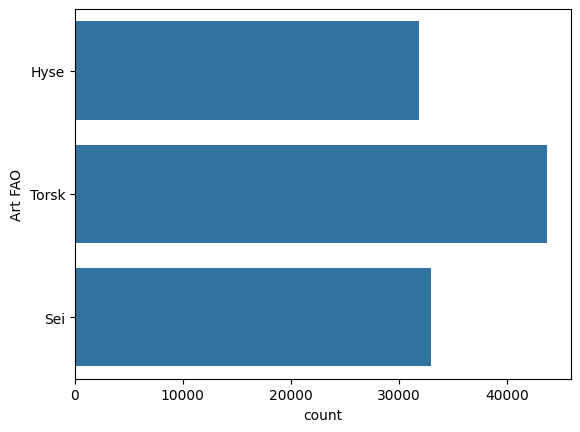

In [137]:
#counting species
print(df['Art FAO'].value_counts())
#plotting species
sns.countplot(df['Art FAO'])
plt.show()

In [138]:
# Pivoting table

# Pivoting table so rows that are information about the same session are put together
df = df.pivot_table(index=['Melding ID', 'Startposisjon bredde', 'Startposisjon lengde',
                           'Havdybde start', 'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand',
                           'Redskap FAO', 'Hovedart FAO','Bruttotonnasje'], columns='Art FAO', values='Rundvekt', aggfunc='sum').reset_index()
# This creates a lot of nan values which we fill with 0
df = df.fillna(0)

print(f"After pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")

After pre-processing the dataset has 15 columns and 51075 rows


In [139]:
# Scaling and one-hot encoding features

# Scale the numerical features. During testing of the models it seemed to have little to no difference for the random forest model.
# But we keep them this way in case other models find them useful.
from sklearn.preprocessing import RobustScaler
num_feat = df[['Melding ID', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
        'Varighet','Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Bruttotonnasje']]
scaler = RobustScaler()
scaled_features = scaler.fit_transform(num_feat)
scaled_df = pd.DataFrame(scaled_features, columns=num_feat.columns)

In [140]:
# One-hot encode the categorical features. 
from sklearn.preprocessing import OneHotEncoder
cat_feat = df[["Redskap FAO", "Hovedart FAO"]]
encoder = OneHotEncoder()
enc_feat= encoder.fit_transform(cat_feat)
enc_df = pd.DataFrame(enc_feat.toarray(), columns=encoder.get_feature_names_out())

# Concatonate the changed features
features = pd.concat([enc_df, scaled_df], axis=1)
# Isolate the targets
targets = df[['Hyse', 'Sei', 'Torsk']]

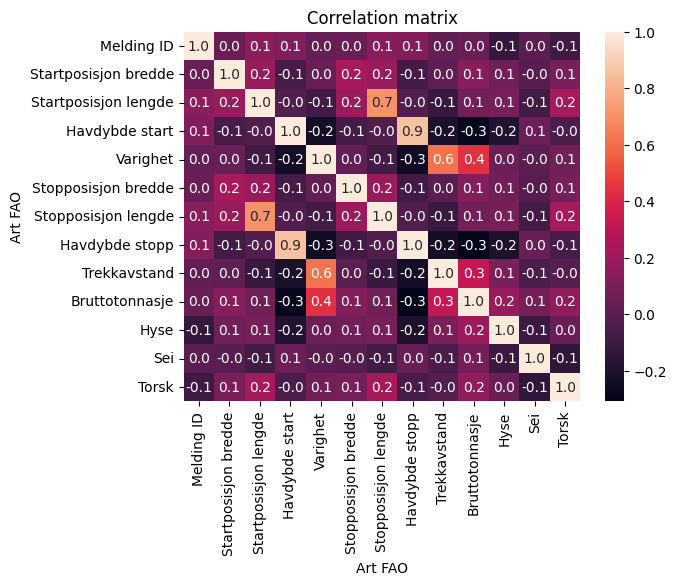

In [141]:
df_corr = df[['Melding ID', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start','Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Bruttotonnasje', 'Hyse', 'Sei', 'Torsk']]
#plotting the correlation matrix
sns.heatmap(df_corr.corr(), annot=True, fmt=".1f" )  #.1ft for using one decimal
plt.title('Correlation matrix')
plt.show() #the correlation matrix does not really tell us any strong relationships between relevant features. The non-linear relationships could still be useful for the model though.

#### Testing models and further exploration of data

Because decision trees are good when there is a different mix of features we have decided to use random forest to even out the downsides of single decision trees. As en extension of that we have decided to use a gradiant boost model as our second model.

##### Baseline RandomForestRegressor

In [142]:
#using random forest without optimization for creating a baseline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


X_train, X_test, y_train, y_test = train_test_split(scaled_df, targets, test_size=0.2, random_state=seed)
rfr = RandomForestRegressor(n_estimators=200, max_features=25, max_depth=40)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"R2: {r2}, RMSE: {rmse}.")

R2: 0.5832246905978602, RMSE: 4142.830609818791.


##### RandomForestRegressor with encoded values + scaled

In [143]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=seed)

# After testing various parameters we chose to go with n_estimators=200, max_features=25, max_depth=40 for this dataset
# The features seemed to be best from 20 upwards. Depth was best between 25-40, from 45 it seemed to go down in performance befroe picking it up again at 70.
# We only tested up to 300 estimators, and it seemed to increase performance slightly all the way up, but for running time we are currently using 200.
rfr = RandomForestRegressor(n_estimators=200, max_features=25, max_depth=40)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"R2: {r2}, RMSE: {rmse}.")

R2: 0.645771470635914, RMSE: 3897.424907480499.


##### GradientBoostingRegressor with encoded values + scaled

In [145]:
#using gradient boosted regression tree
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=200, max_features=25, max_depth=40)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"R2: {r2}, RMSE: {rmse}.")

ValueError: y should be a 1d array, got an array of shape (38306, 3) instead.

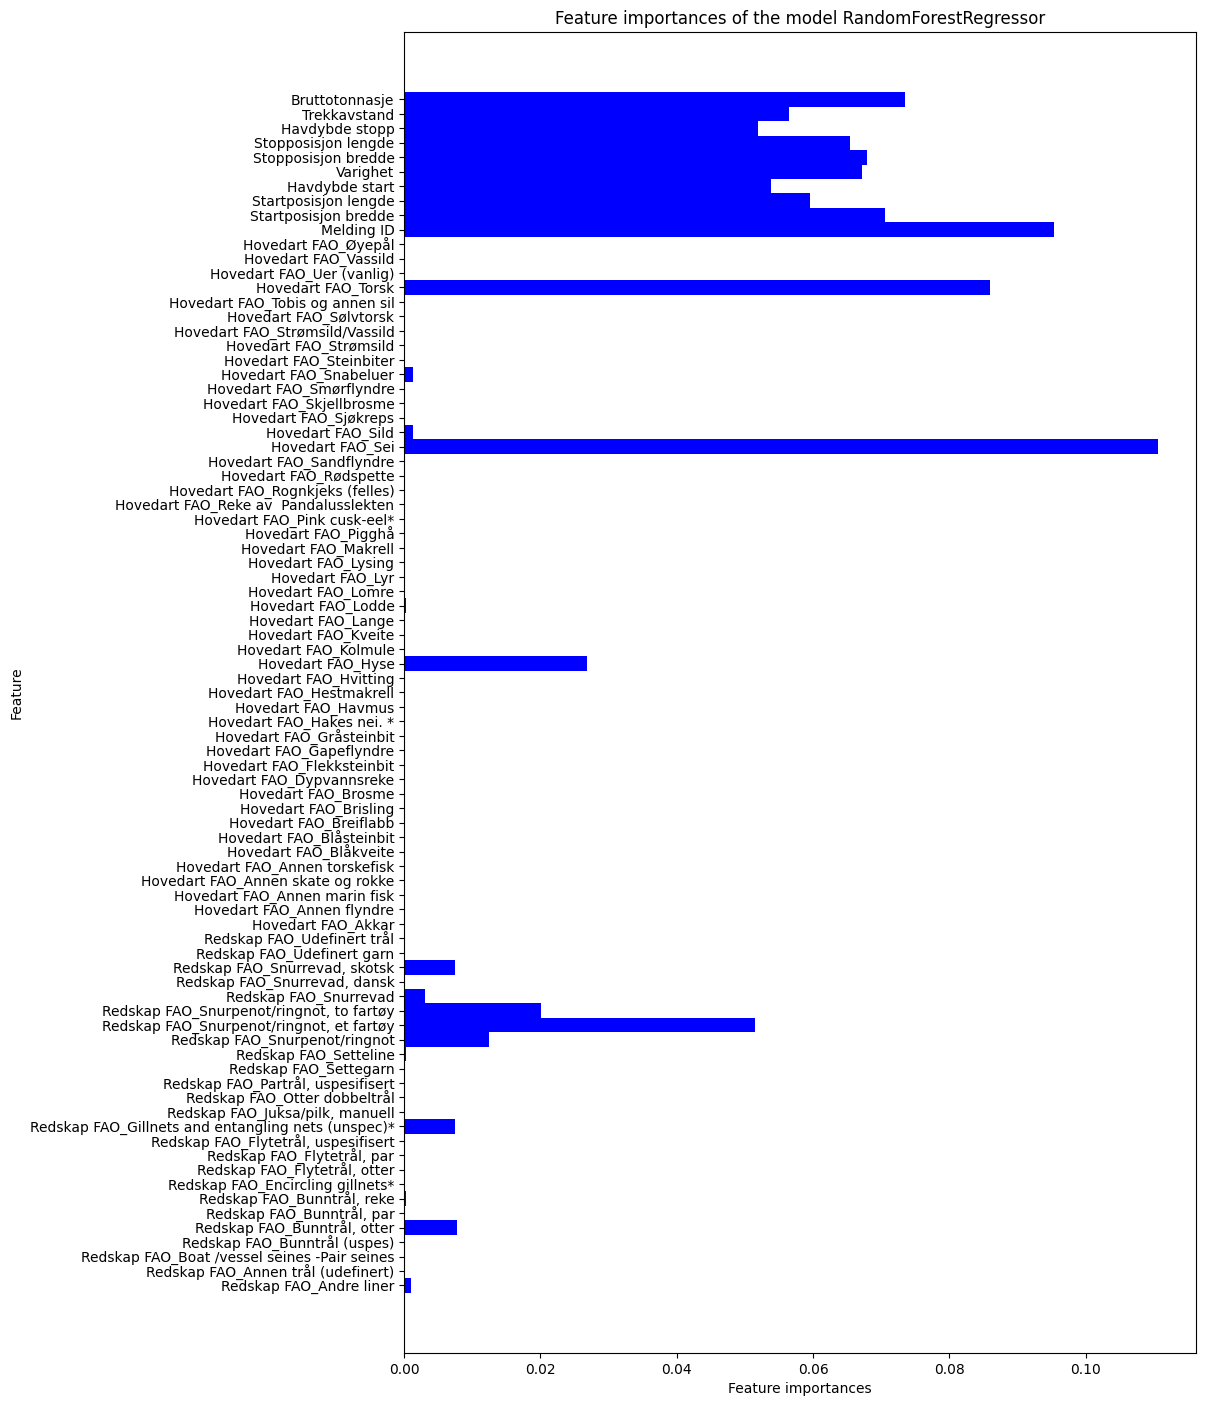

In [ ]:

def plot_feature_importances(model, feature_columns):
    n_features = len(feature_columns.columns)
    feature_indices = feature_columns.columns.tolist()
    feature_importances = model.feature_importances_

    fig = plt.figure(figsize=(12,14))
    plt.subplot(111)
    plt.barh(range(n_features), feature_importances, height=1, color='b', align='center')
    plt.yticks(np.arange(n_features), feature_indices[:n_features])
    plt.xlabel("Feature importances")
    plt.ylabel("Feature")
    plt.title("Feature importances of the model {}".format(model.__class__.__name__))
    plt.tight_layout(pad=0.5)

plot_feature_importances(rfr, features)

# This graph shows the feature importance of the randomforest model.
# A lot of the one-hot encoded features seem to have no importance. We tried collapsing all the seemingly irrelevant ones into a single column.
# That seemed to worsen the R2 score from 0.637-642 to around 0.44 so we've decided to keep them for now even though this graph seems to indicate their lack of importance.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
# From testing: putting the learning rate at 0.3 or above seems to make results worse. Setting depth over 10 seems to do the same and increase the runtime a lot.
# We will do some more rounds of testing, but for now are settling on a depth of 7, learning rate of 0.8. Number of estimators hasent been tested yet, so for now its a standard of 100.

X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=seed)

base_estimator = GradientBoostingRegressor(n_estimators=100, learning_rate=0.8, max_depth=7, random_state=seed)
        
multioutput_regressor = MultiOutputRegressor(base_estimator)
        
multioutput_regressor.fit(X_train, y_train)
        
y_pred = multioutput_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"R2: {r2}, RMSE: {rmse}.")

# Their is certainly room for combing other gradient boosting techqniues, such as XGBoost, LightGBM or CatBoost with the randomforest model.

R2: 0.42780924716299146, RMSE: 4860.497408561845.


In [ ]:
#Decided to use the MLPRegressor model as the deep learning model, since it is the most relevant for our regression problem. Using one hot encoded values, continuous values and scaled values. 
from sklearn.neural_network import MLPRegressor
from math import sqrt

X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=seed)
#creating the model
model = MLPRegressor(random_state=seed, max_iter=1000, verbose=True, hidden_layer_sizes=(100, 50, 25, 10), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,shuffle=True,  early_stopping=True)
model.fit(X_train, y_train)
#currently in testing phase of understanding and using the correct parameters for the model.
#predicting the test data
y_pred = model.predict(X_test)
print(y_pred.round(2))
#returning the result
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean squared error: {rmse}")
#r2 score
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2}")

Iteration 1, loss = 21643437.14705973
Iteration 2, loss = 18253473.84748916
Iteration 3, loss = 17802704.17035028
Iteration 4, loss = 17464595.75320035
Iteration 5, loss = 15236066.86486827
Iteration 6, loss = 12414748.34765490
Iteration 7, loss = 11958155.95626886
Iteration 8, loss = 11766422.53590252
Iteration 9, loss = 11549745.34841911
Iteration 10, loss = 11149781.23302352
Iteration 11, loss = 10746130.42318271
Iteration 12, loss = 10612984.00381042
Iteration 13, loss = 10551398.93747965
Iteration 14, loss = 10504247.93941387
Iteration 15, loss = 10459698.46763669
Iteration 16, loss = 10423292.23125814
Iteration 17, loss = 10381563.21277695
Iteration 18, loss = 10343691.95802422
Iteration 19, loss = 10303214.76272288
Iteration 20, loss = 10267124.74412889
Iteration 21, loss = 10245499.33053995
Iteration 22, loss = 10206080.14811964
Iteration 23, loss = 10172581.76208021
Iteration 24, loss = 10142947.69456319
Iteration 25, loss = 10111119.49105102
Iteration 26, loss = 10075931.0372

Text(0.5, 1.0, 'R2 scores of the models')

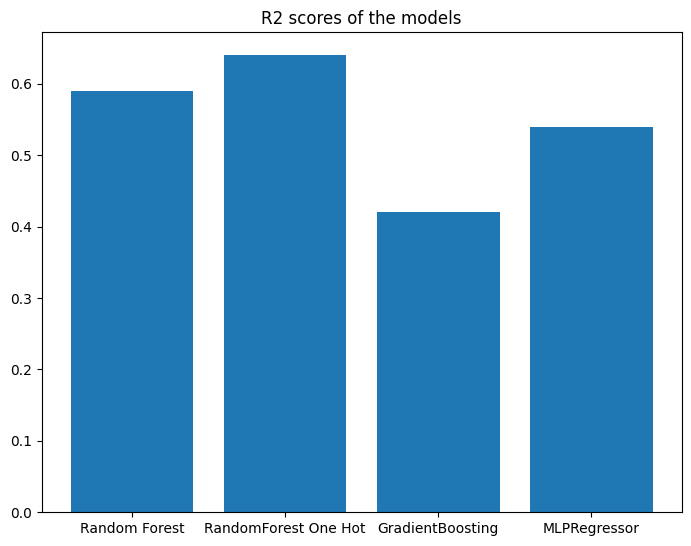

In [ ]:
#plotting all the r2 scores from each model
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#title
models = ['Random Forest','RandomForest One Hot', 'GradientBoosting', 'MLPRegressor']
r2_scores = [0.59,0.64, 0.42, 0.54]
ax.bar(models,r2_scores)
plt.title('R2 scores of the models')